# Combine Different Magnifications

How to combine multiple datasets of the same target particle captured at different magnifications for later-stage post-processing and refinement.

```{note}
The datasets must be processed independently as far as possible before combining for use in later-stage Refinement and Reconstruction jobs that require all particles to maximize resolution.

The resulting combined particles dataset are the output of independent Select 2D jobs with the final sets of particles for refinement.
```

## Project Setup

This example uses two modified [EMPIAR 10025 T20S Proteasome](https://www.ebi.ac.uk/empiar/EMPIAR-10025/) subsets with following respective pixel sizes:
* 0.66 Å
* 0.88 Å

Import the movies or micrographs in separate jobs, each job including only exposures of distinct pixel sizes. Process each set **independently** (i.e., do not combine the datasets yet). For this example, the following pre-processing jobs run independently on each dataset:
* Patch Motion Correction
* Patch CTF Estimation
* Template Picker
* Extract Particles (**use the same box size for all datasets**)
* 2D Classification
* Select 2D Classes

```{note}
Use the same box size when extracting particles. Refinements with different box sizes are not supported. It may be necessary to reduce the Circular mask diameter parameter in 2D Classification for the lower-magnification datasets.
```

Finally, use Ab-Initio Reconstruction to generate an initial volume with **only the first particles dataset**.


## Load Datasets

Connect to CryoSPARC and access the project instance.

In [1]:
from cryosparc.tools import CryoSPARC

cs = CryoSPARC(host="cryoem5", port=61000)
assert cs.test_connection()

project = cs.find_project("P70")

Connection succeeded to cryoSPARC command_core at http://cryoem5:61002
Connection succeeded to cryoSPARC command_vis at http://cryoem5:61003


Optionally preview the selected 2D classes from each selected dataset to compare the magnification differences. Here are the classes for the first dataset:

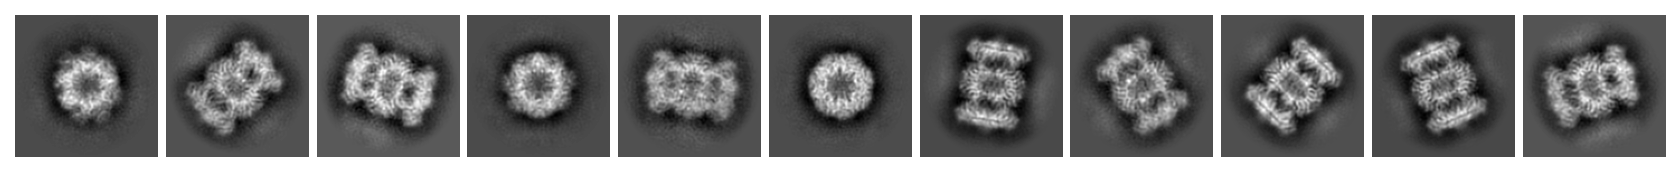

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

select2d_job_1 = project.find_job("J104")
templates_selected_1 = select2d_job_1.load_output("templates_selected")
unique_mrc_paths_1 = set(templates_selected_1["blob/path"])
all_templates_blobs_1 = {path: project.download_mrc(path)[1] for path in unique_mrc_paths_1}

fig = plt.figure(figsize=(len(templates_selected_1), 1), dpi=150)
plt.margins(x=0, y=0)

for i, template in enumerate(templates_selected_1.rows()):
    path = template["blob/path"]
    index = template["blob/idx"]
    blob = all_templates_blobs_1[path][index]
    plt.subplot(1, len(templates_selected_1), i + 1)
    plt.axis("off")
    plt.imshow(blob, cmap="gray", origin="lower")

fig.tight_layout(pad=0, h_pad=0.4, w_pad=0.4)

And for the second dataset:

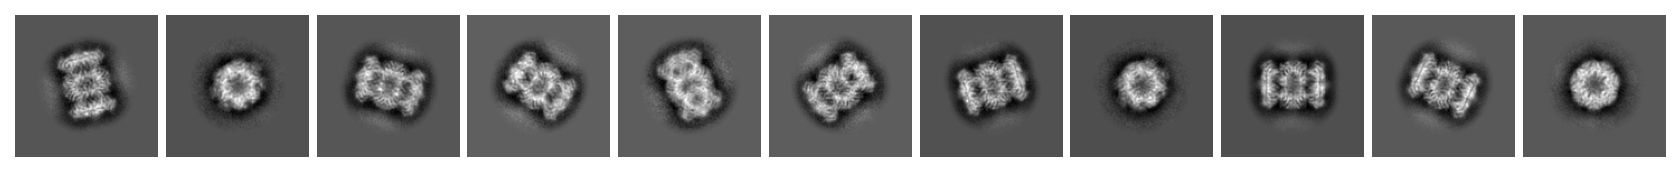

In [3]:
select2d_job_2 = project.find_job("J105")
templates_selected_2 = select2d_job_2.load_output("templates_selected")
unique_mrc_paths_2 = set(templates_selected_2["blob/path"])
all_templates_blobs_2 = {path: project.download_mrc(path)[1] for path in unique_mrc_paths_2}

fig = plt.figure(figsize=(len(templates_selected_2), 1), dpi=150)
plt.margins(x=0, y=0)

for i, template in enumerate(templates_selected_2.rows()):
    path = template["blob/path"]
    index = template["blob/idx"]
    blob = all_templates_blobs_2[path][index]
    plt.subplot(1, len(templates_selected_2), i + 1)
    plt.axis("off")
    plt.imshow(blob, cmap="gray", origin="lower")

fig.tight_layout(pad=0, h_pad=0.4, w_pad=0.4)

Note the differences in magnification between the two datasets.

## Set up External Job

Create a new External Job. Connect the Select 2D outputs as separate inputs. Note that the particles must have `location`, `blob` and `ctf` input slots.

In [12]:
job = project.create_external_job("W5", title="Combine Magnifications")
# job = project.find_external_job("J109")
job.connect("J104", "particles_selected", "particles_1", slots=["location", "blob", "ctf"])
job.connect("J105", "particles_selected", "particles_2", slots=["location", "blob", "ctf"])
job.add_output("particle", name="combined_particles", slots=["location", "blob", "ctf"])
job.start()

Start the job and load the two datasets. Take a sample the first 5 particles from each dataset and note the relevant fields for each:

In [16]:
import pandas as pd

particles_1 = job.load_input("particles_1")
particles_2 = job.load_input("particles_2")

samples = particles_1.slice(0, 5).append(particles_2.slice(0, 5)).filter_fields(["blob/psize_A", "ctf/anisomag"])

pd.DataFrame(samples.rows())

,blob/psize_A,ctf/anisomag,uid
0,0.657500,"[0.0, 0.0, 0.0, 0.0]",8362351900999537333
1,0.657500,"[0.0, 0.0, 0.0, 0.0]",17531430844250197001
2,0.657500,"[0.0, 0.0, 0.0, 0.0]",12005404851891275504
3,0.657500,"[0.0, 0.0, 0.0, 0.0]",2229534581309443518
4,0.657500,"[0.0, 0.0, 0.0, 0.0]",17564754910888403303
5,0.876667,"[0.0, 0.0, 0.0, 0.0]",15261960299866684077
6,0.876667,"[0.0, 0.0, 0.0, 0.0]",2702208441223592716
7,0.876667,"[0.0, 0.0, 0.0, 0.0]",12372622674876323250
8,0.876667,"[0.0, 0.0, 0.0, 0.0]",14975780653177228151
9,0.876667,"[0.0, 0.0, 0.0, 0.0]",13256565853396032240


The `ctf/anisomag` column represents each particle's anisotropic magnification. It is a 2x2 matrix $[\begin{array}{cc} a & b \\ c & d \end{array}]$, where elements are stored sequentially in row-major order $[\begin{array}{cc} a & b & c & d \end{array}]$. A magnification value of $[\begin{array}{cc} 0.0 & 0.0 & 0.0 & 0.0 \end{array}]$ means no magnification is applied.

## Update the Magnification on the Second Dataset

Calculate a new anisotropic magnification matrix for the second particles dataset (`particles_2`): Reshape the `ctf/anisomag` column so that each element has shape `(2, 2)` instead of `(4,)`. Add the identity matrix $[\begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array}]$. Multiply by the ratio of the two pixel sizes and subtract the identity matrix.

In [19]:
import numpy as np

nrows_2 = len(particles_2)
psize_1 = particles_1["blob/psize_A"][0]
psize_2 = particles_2["blob/psize_A"][0]

mag_2 = particles_2["ctf/anisomag"].reshape((nrows_2, 2, 2))
updated_mag_2 = (mag_2 + np.eye(2)) * psize_2 / psize_1 - np.eye(2)

particles_2["blob/psize_A"] = psize_1
particles_2["ctf/anisomag"] = updated_mag_2.reshape((nrows_2, 4))

updated_samples = particles_2.slice(0, 5).filter_fields(["blob/psize_A", "ctf/anisomag"])

pd.DataFrame(updated_samples.rows())

,blob/psize_A,ctf/anisomag,uid
0,0.6575,"[0.33333337, 0.0, 0.0, 0.33333337]",15261960299866684077
1,0.6575,"[0.33333337, 0.0, 0.0, 0.33333337]",2702208441223592716
2,0.6575,"[0.33333337, 0.0, 0.0, 0.33333337]",12372622674876323250
3,0.6575,"[0.33333337, 0.0, 0.0, 0.33333337]",14975780653177228151
4,0.6575,"[0.33333337, 0.0, 0.0, 0.33333337]",13256565853396032240


The two datasets now have the same pixel size but different magnification values. Append them and save to a single combined output.

In [18]:
combined_particles = particles_1.append(particles_2)
job.save_output("combined_particles", combined_particles)
job.stop()

The resuting combined dataset may be used with the following post-processing jobs.

* Homogeneous Refinement
* Homogeneous Reconstruction
* Non-Uniform Refinement
* 3D Classification
* 3D Variability
* Local Refinement

_Avoid_ using the particles with the following jobs:

* 2D Classification
* Ab-Initio Reconstruction
* Helical Refinement
